<a href="https://colab.research.google.com/github/kesavan14215/AIML_PowerPulse-HouseholdEnergyUsageForecast/blob/main/PowerPulse_Household_Energy_Usage_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install ucimlrepo


In [38]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
data = individual_household_electric_power_consumption.data.features
#y = individual_household_electr ic_power_consumption.data.targets

# metadata
#print(individual_household_electric_power_consumption.metadata)

# variable information
#print(individual_household_electric_power_consumption.variables)


/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
from scipy import stats


In [40]:

"""
Load the dataset and data preprocessing steps
"""

f_df = data
f_df['Datetime'] = pd.to_datetime(f_df['Date'] + ' ' + f_df['Time'])
f_df = f_df.drop(['Date','Time'],axis=1)
# Convert '?' to NaN and then to float
for column in  f_df.columns:
  if column != 'Datetime':
        f_df[column] = pd.to_numeric( f_df[column].replace('?', np.nan))

print("f_dfset Overview:")
print(f"Shape: { f_df.shape}")
print("\nColumns:",  f_df.columns.tolist())

f_df.head()

<ipython-input-40-610979299d1e>:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  f_df['Datetime'] = pd.to_datetime(f_df['Date'] + ' ' + f_df['Time'])


f_dfset Overview:
Shape: (2075259, 8)

Columns: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Datetime']


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [41]:

"""
Create additional features for better prediction
"""

# Extract temporal features
f_df['hour'] = f_df['Datetime'].dt.hour
f_df['day_of_week'] = f_df['Datetime'].dt.dayofweek
f_df['month'] = f_df['Datetime'].dt.month
f_df['is_weekend'] = f_df['day_of_week'].isin([5, 6]).astype(int)

#Create rolling averages to calculate 24 hour consuptions
f_df['rolling_mean_24h'] = f_df['Global_active_power'].rolling(window=24).mean()


# Calculate peak hours flag based on the below plot and consider values greater than 5
#sns.barplot(x='hour', y='Global_intensity', data=f_df)
#plt.axhline(y=5, linestyle="--", color="red")
#plt.show()

#manully updating from plot
peak_hours = [7,8,9,10,11,12,18,19,20,21,22]
f_df['is_peak_hour'] = f_df['hour'].isin(peak_hours).astype(int)

# Create interaction features
f_df['power_hour_interaction'] = f_df['Global_active_power'] * f_df['hour']

# Calculate lagged features
f_df['power_lag_1h'] = f_df['Global_active_power'].shift(1)
f_df['power_lag_24h'] = f_df['Global_active_power'].shift(24)


#basic_statistics()
print("f_dfset Overview:")
print(f"Shape: { f_df.shape}")
print("\nColumns:",  f_df.columns.tolist())

f_df.head()

f_dfset Overview:
Shape: (2075259, 17)

Columns: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Datetime', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean_24h', 'is_peak_hour', 'power_hour_interaction', 'power_lag_1h', 'power_lag_24h']


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,hour,day_of_week,month,is_weekend,rolling_mean_24h,is_peak_hour,power_hour_interaction,power_lag_1h,power_lag_24h
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,17,5,12,1,NaN,0,71.672,NaN,NaN
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,17,5,12,1,NaN,0,91.120,4.216,NaN
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,17,5,12,1,NaN,0,91.358,5.360,NaN
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,17,5,12,1,NaN,0,91.596,5.374,NaN
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,17,5,12,1,NaN,0,62.322,5.388,NaN


In [42]:
"""EDA analysis"""


def basic_statistics( ):
    """Display basic statistics of the f_dfset"""
    print("\nBasic Statistics:")
    print("\nMissing Values:")
    print( f_df.isnull().sum())

    print("\nNumerical Statistics:")
    print( f_df.describe())

    print("\nf_df Types:")
    print( f_df.dtypes)

def plot_missing_values(data ):
    """Visualize missing values"""
    plt.figure(figsize=(10, 6))
    sns.heatmap( data.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap')
    #plt.tight_layout()
    plt.show()


def plot_distributions(data):
    """Plot distributions of all numerical variables"""
    numerical_cols =  data.select_dtypes(include=['float64', 'int32','int64']).columns

    n_cols = 2
    n_rows = (len(numerical_cols) + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.ravel()

    for idx, col in enumerate(numerical_cols):
        # Histogram
        sns.histplot(data= data, x=col, ax=axes[idx], kde=True)
        axes[idx].set_title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

    # Box plots
    plt.figure(figsize=(15, 6))
    if not isinstance(numerical_cols, list):
        numerical_cols = numerical_cols.tolist()
    data.boxplot(column=numerical_cols)
    plt.xticks(rotation=45)
    plt.title('Box Plots of Numerical Variables')
    plt.tight_layout()
    plt.show()

def plot_correlations( data ):
    """Plot correlation matrix"""
    numerical_cols =  data.select_dtypes(include=['float64', 'int32','int64']).columns
    corr_matrix =  data[numerical_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

def temporal_analysis( ):
    """Analyze temporal patterns"""
    # Hourly patterns
    plt.figure(figsize=(15, 5))
    hourly_avg =  f_df.groupby('hour')['Global_active_power'].mean()
    sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
    plt.title('Average Power Consumption by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Global Active Power')
    plt.tight_layout()
    plt.show()

    # Daily patterns
    plt.figure(figsize=(15, 5))
    daily_avg =  f_df.groupby('day_of_week')['Global_active_power'].mean()
    sns.barplot(x=daily_avg.index, y=daily_avg.values)
    plt.title('Average Power Consumption by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Global Active Power')
    plt.tight_layout()
    plt.show()

    # Monthly patterns
    plt.figure(figsize=(15, 5))
    monthly_avg =  f_df.groupby('month')['Global_active_power'].mean()
    sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
    plt.title('Average Power Consumption by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Global Active Power')
    plt.tight_layout()
    plt.show()

def plot_submetering_comparison( ):
    """Compare submetering readings"""
    sub_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

    # Daily averages
    daily_avg =  f_df.groupby( f_df['Datetime'].dt.date)[sub_cols].mean()

    plt.figure(figsize=(15, 6))
    for col in sub_cols:
        plt.plot(daily_avg.index, daily_avg[col], label=col)

    plt.title('Daily Average Submetering Comparison')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def identify_outliers( ):
    """Identify and analyze outliers"""
    f_df1 = f_df
    numerical_cols =  f_df1.select_dtypes(include=['float64', 'int32','int64']).columns

    outliers_summary = {}
    for col in numerical_cols:
        Q1 =  f_df1[col].quantile(0.25)
        Q3 =  f_df1[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers_data = (f_df1[col] < Q1 - 1.5*IQR) | ( f_df1[col] > Q3 + 1.5*IQR)
        outliers =  f_df1[outliers_data][col]
        outliers_summary[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len( f_df1)) * 100,
            'min': outliers.min() if len(outliers) > 0 else None,
            'max': outliers.max() if len(outliers) > 0 else None
        }

    print("\nOutliers Summary:")
    for col, stats in outliers_summary.items():
        print(f"\n{col}:")
        print(f"Number of outliers: {stats['count']}")
        print(f"Percentage of outliers: {stats['percentage']:.2f}%")
        if stats['min'] is not None:
            print(f"Min outlier value: {stats['min']:.2f}")
            print(f"Max outlier value: {stats['max']:.2f}")


def removal_outliers( ):
    """Identify and analyze outliers"""
    f_df_no_outliers = f_df
    numerical_cols =  f_df_no_outliers.select_dtypes(include=['float64', 'int32','int64']).columns

    outliers_summary = {}
    for col in numerical_cols:
        Q1 =  f_df_no_outliers[col].quantile(0.25)
        Q3 =  f_df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers_data = (f_df_no_outliers[col] < Q1 - 1.5*IQR) | ( f_df_no_outliers[col] > Q3 + 1.5*IQR)
        f_df_no_outliers = f_df_no_outliers.drop(f_df_no_outliers[outliers_data].index)
        return f_df_no_outliers

def Handle_missing_values(data):
    """Handling missing value """
    return data.ffill()


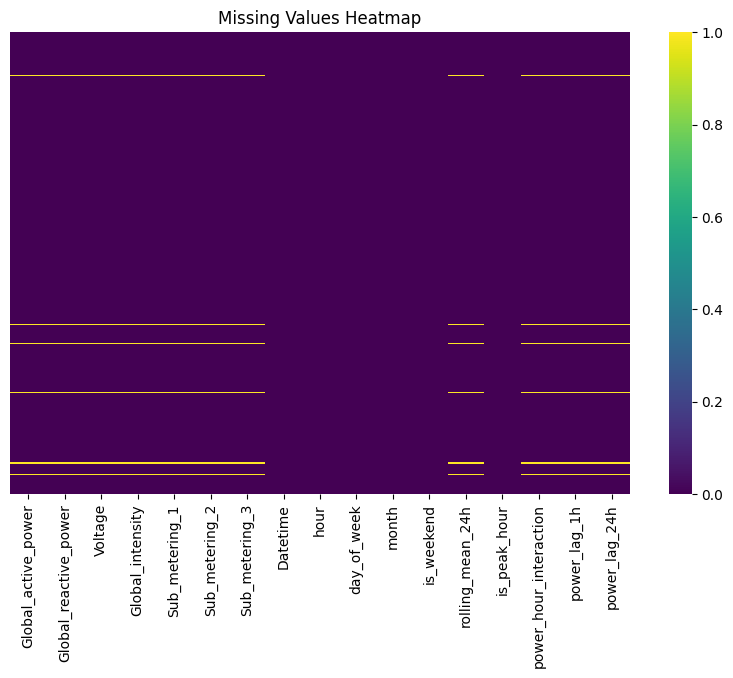

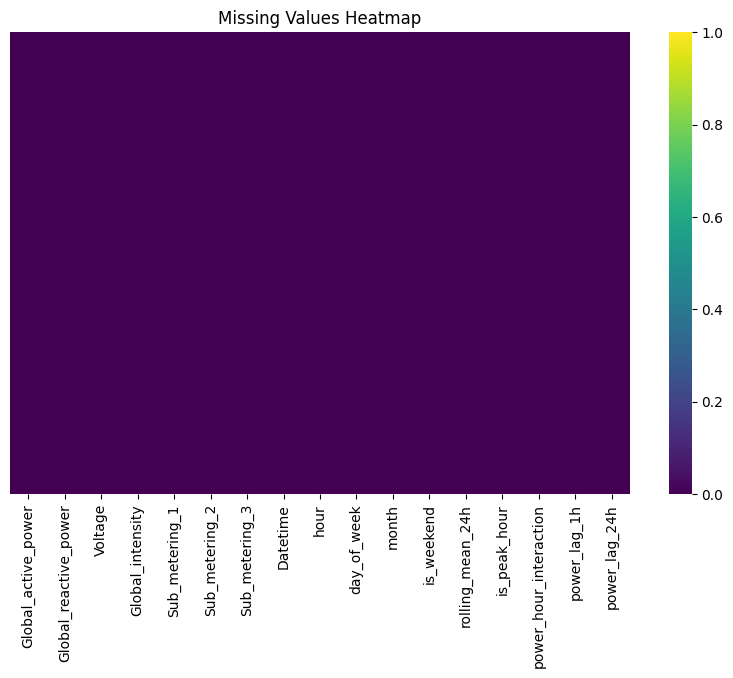

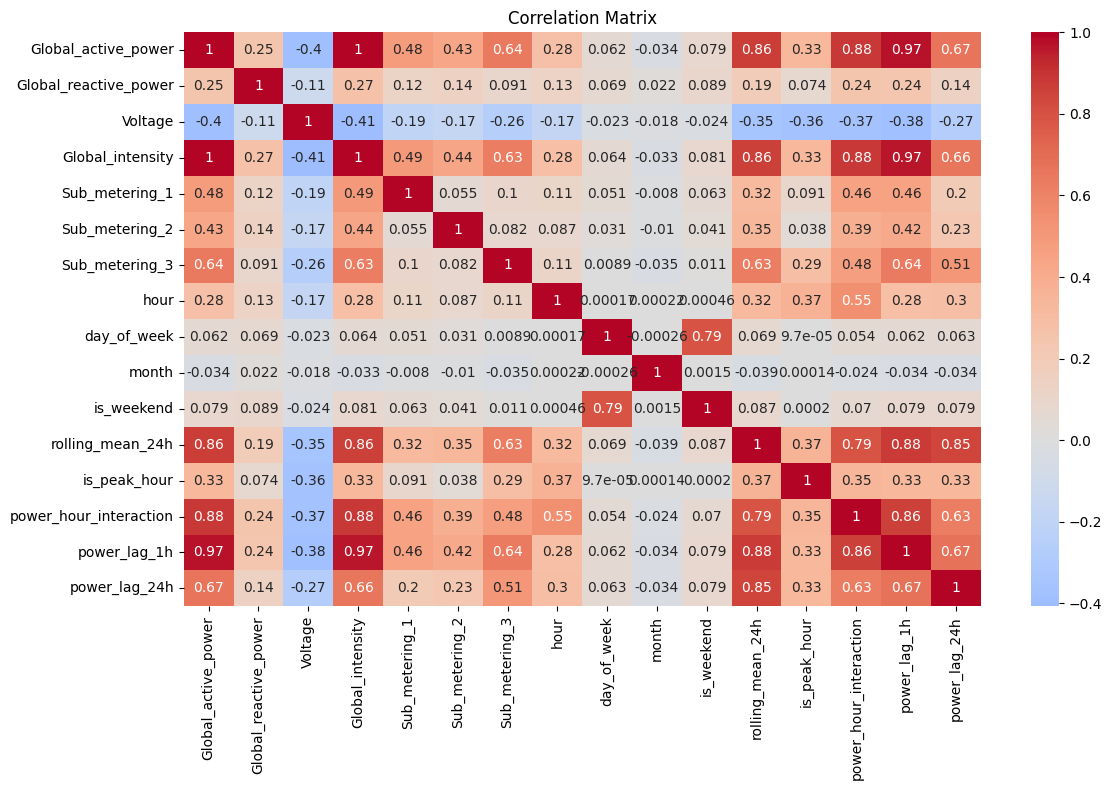

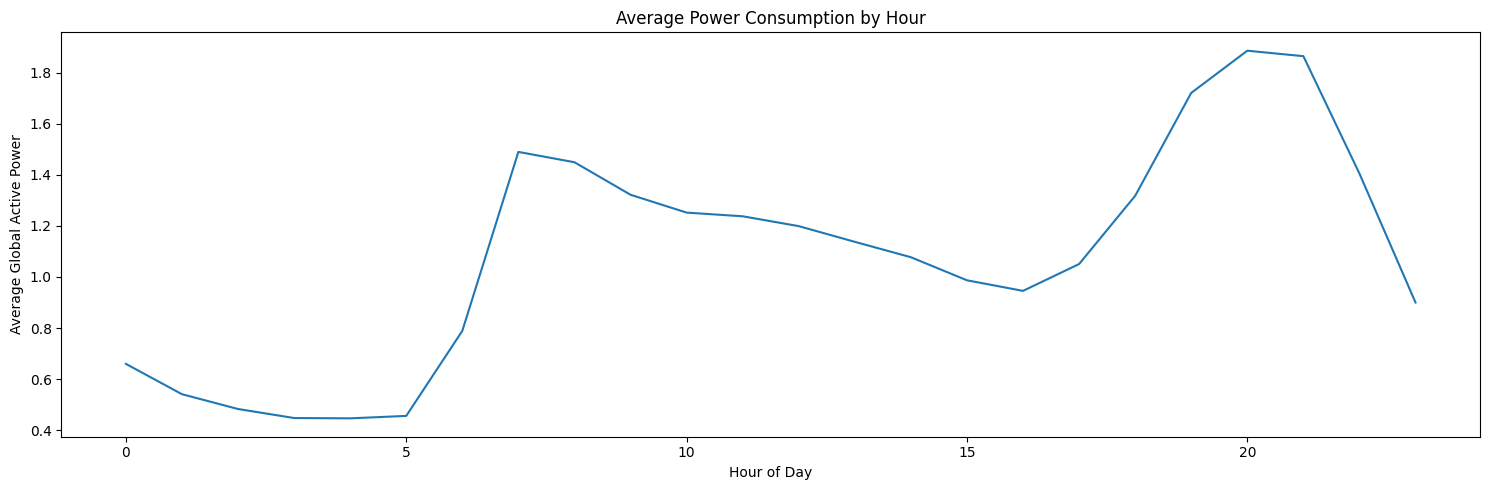

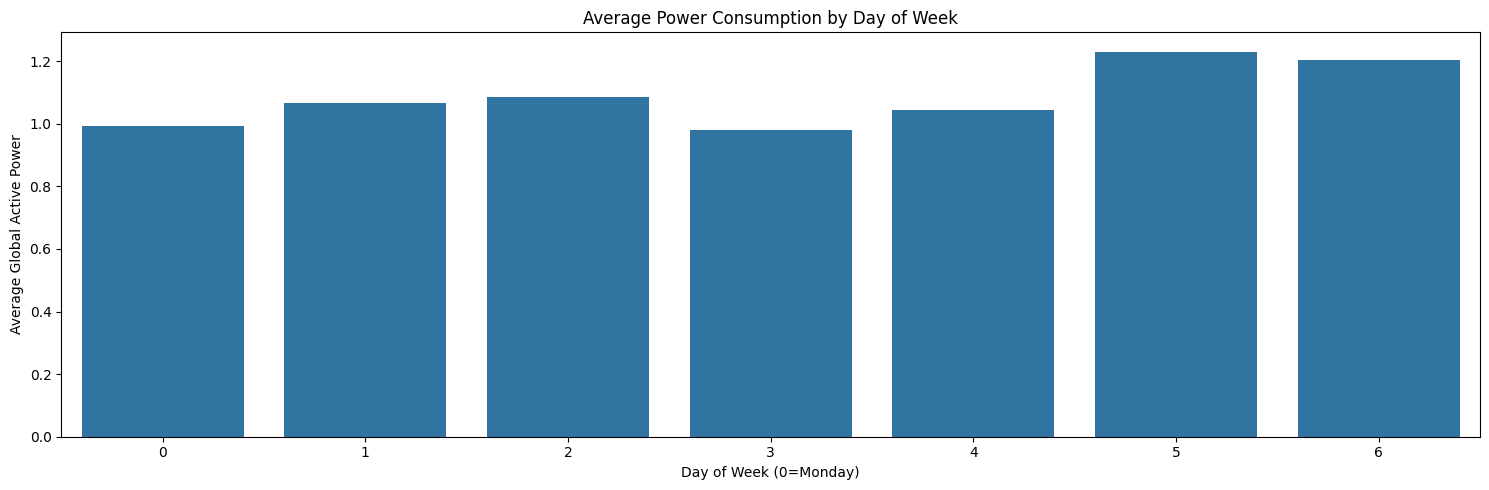

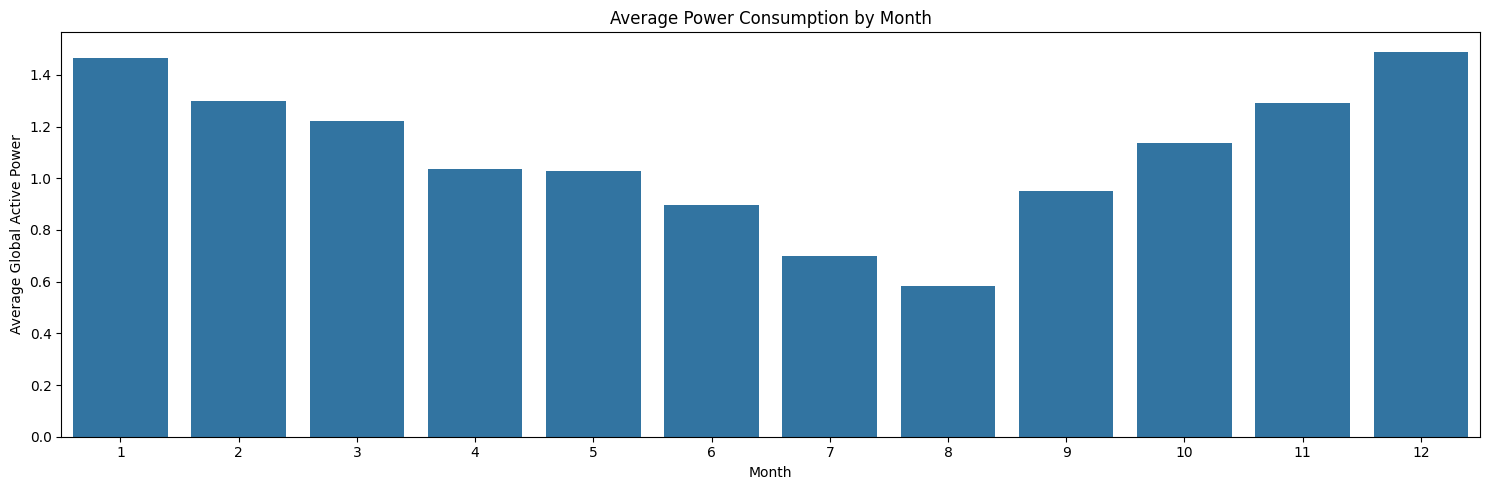

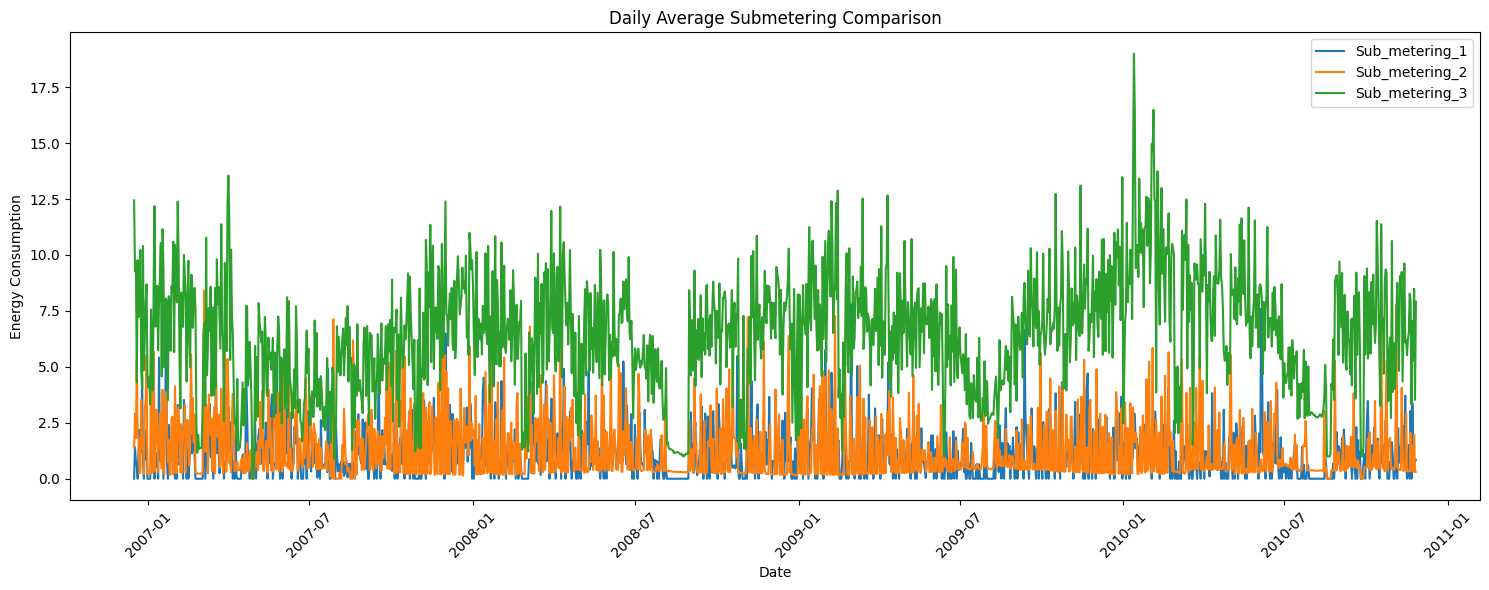


Outliers Summary:

Global_active_power:
Number of outliers: 95699
Percentage of outliers: 4.61%
Min outlier value: 3.35
Max outlier value: 11.12

Global_reactive_power:
Number of outliers: 40509
Percentage of outliers: 1.95%
Min outlier value: 0.41
Max outlier value: 1.39

Voltage:
Number of outliers: 52822
Percentage of outliers: 2.55%
Min outlier value: 223.20
Max outlier value: 254.15

Global_intensity:
Number of outliers: 100977
Percentage of outliers: 4.87%
Min outlier value: 14.00
Max outlier value: 48.40

Sub_metering_1:
Number of outliers: 172246
Percentage of outliers: 8.30%
Min outlier value: 1.00
Max outlier value: 88.00

Sub_metering_2:
Number of outliers: 77156
Percentage of outliers: 3.72%
Min outlier value: 3.00
Max outlier value: 80.00

Sub_metering_3:
Number of outliers: 0
Percentage of outliers: 0.00%

hour:
Number of outliers: 0
Percentage of outliers: 0.00%

day_of_week:
Number of outliers: 0
Percentage of outliers: 0.00%

month:
Number of outliers: 0
Percentage of

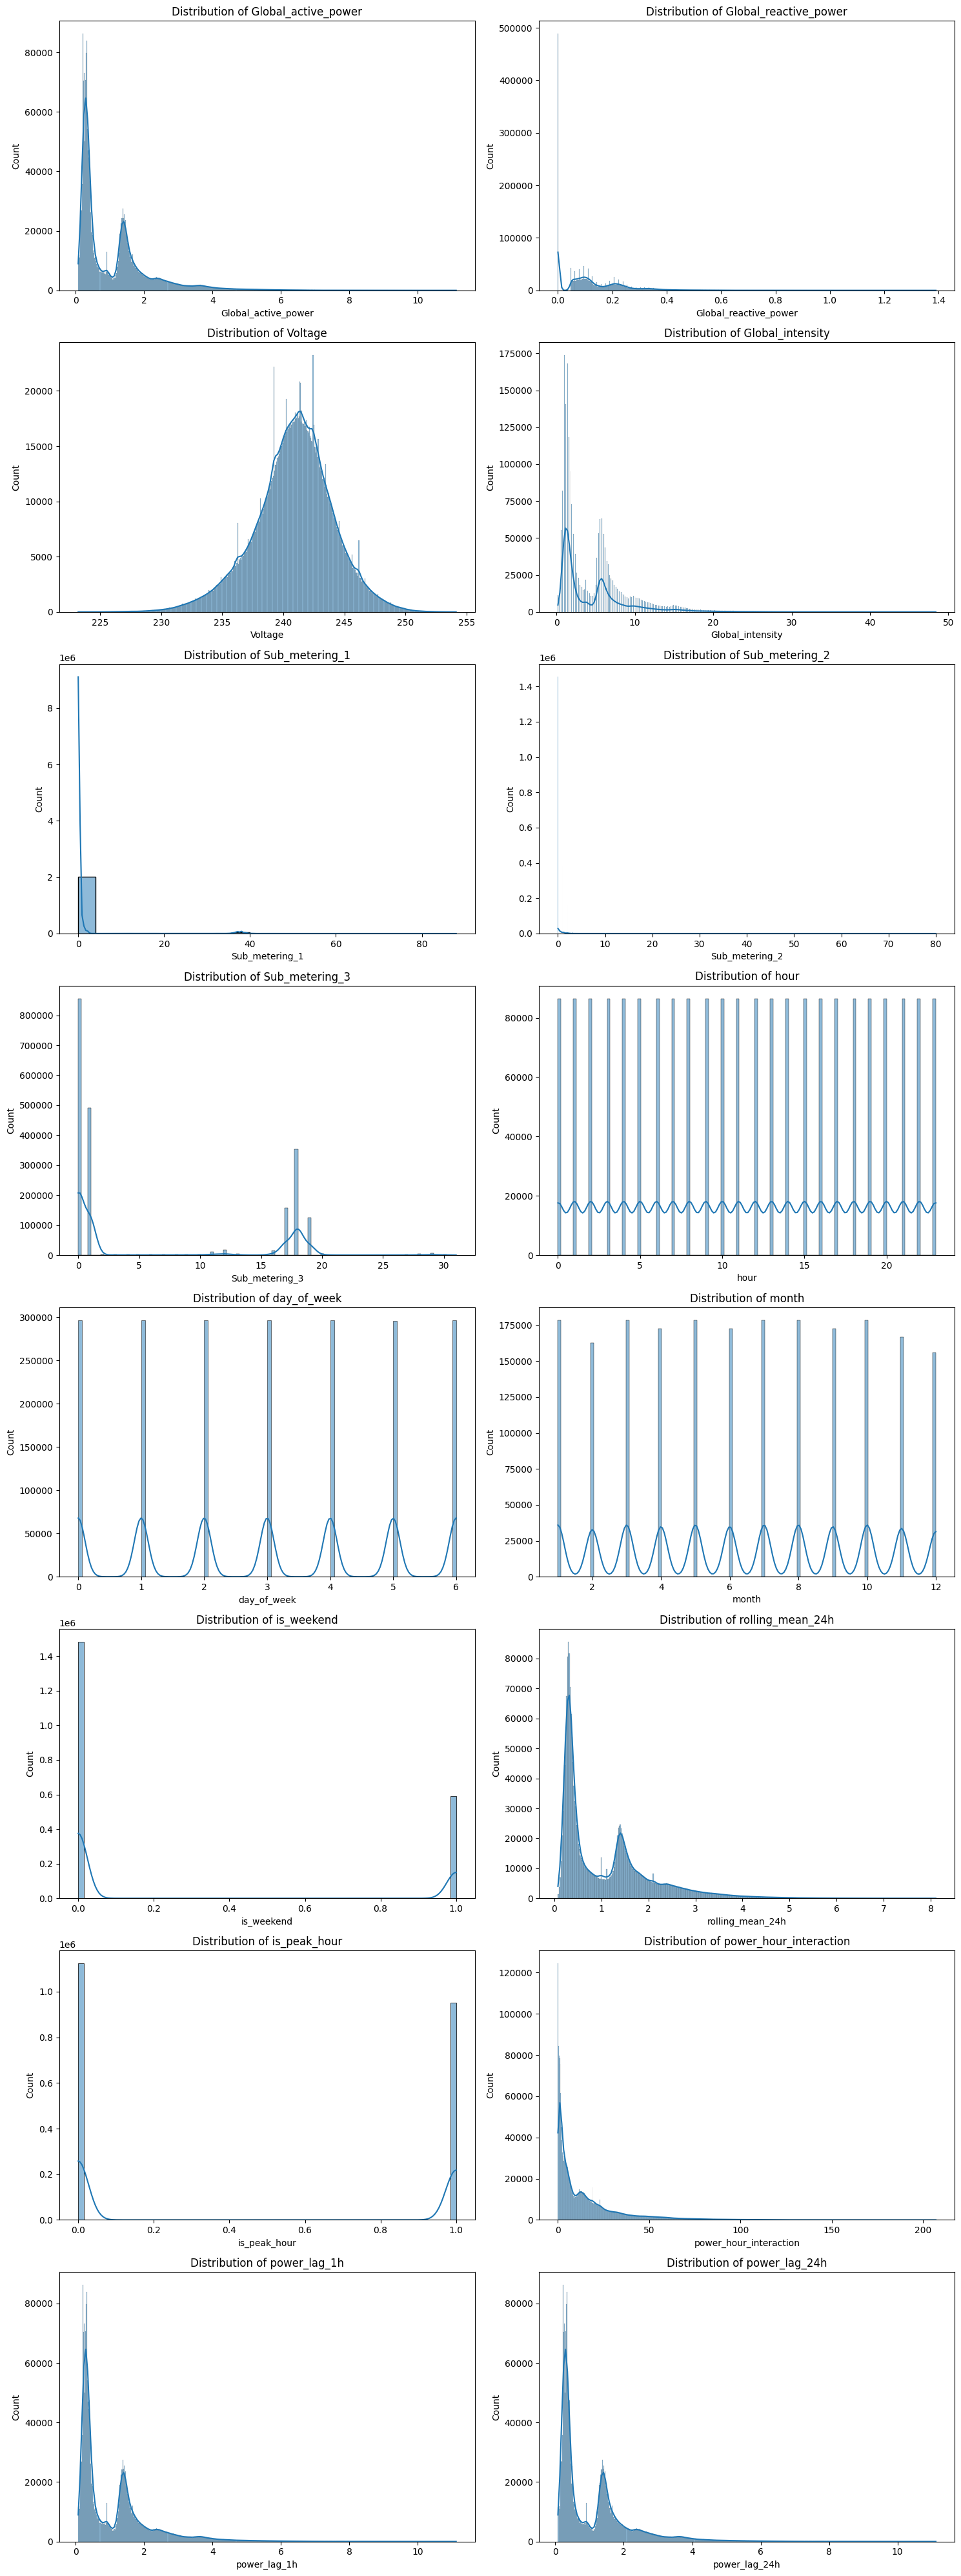

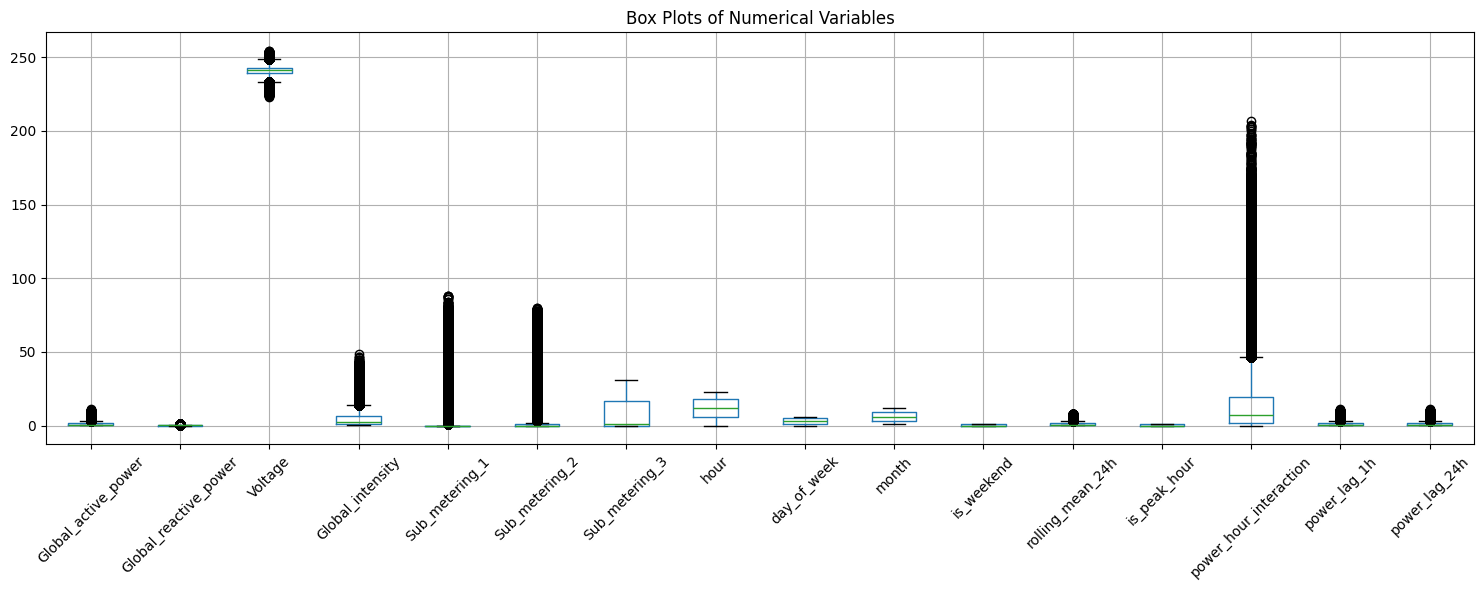

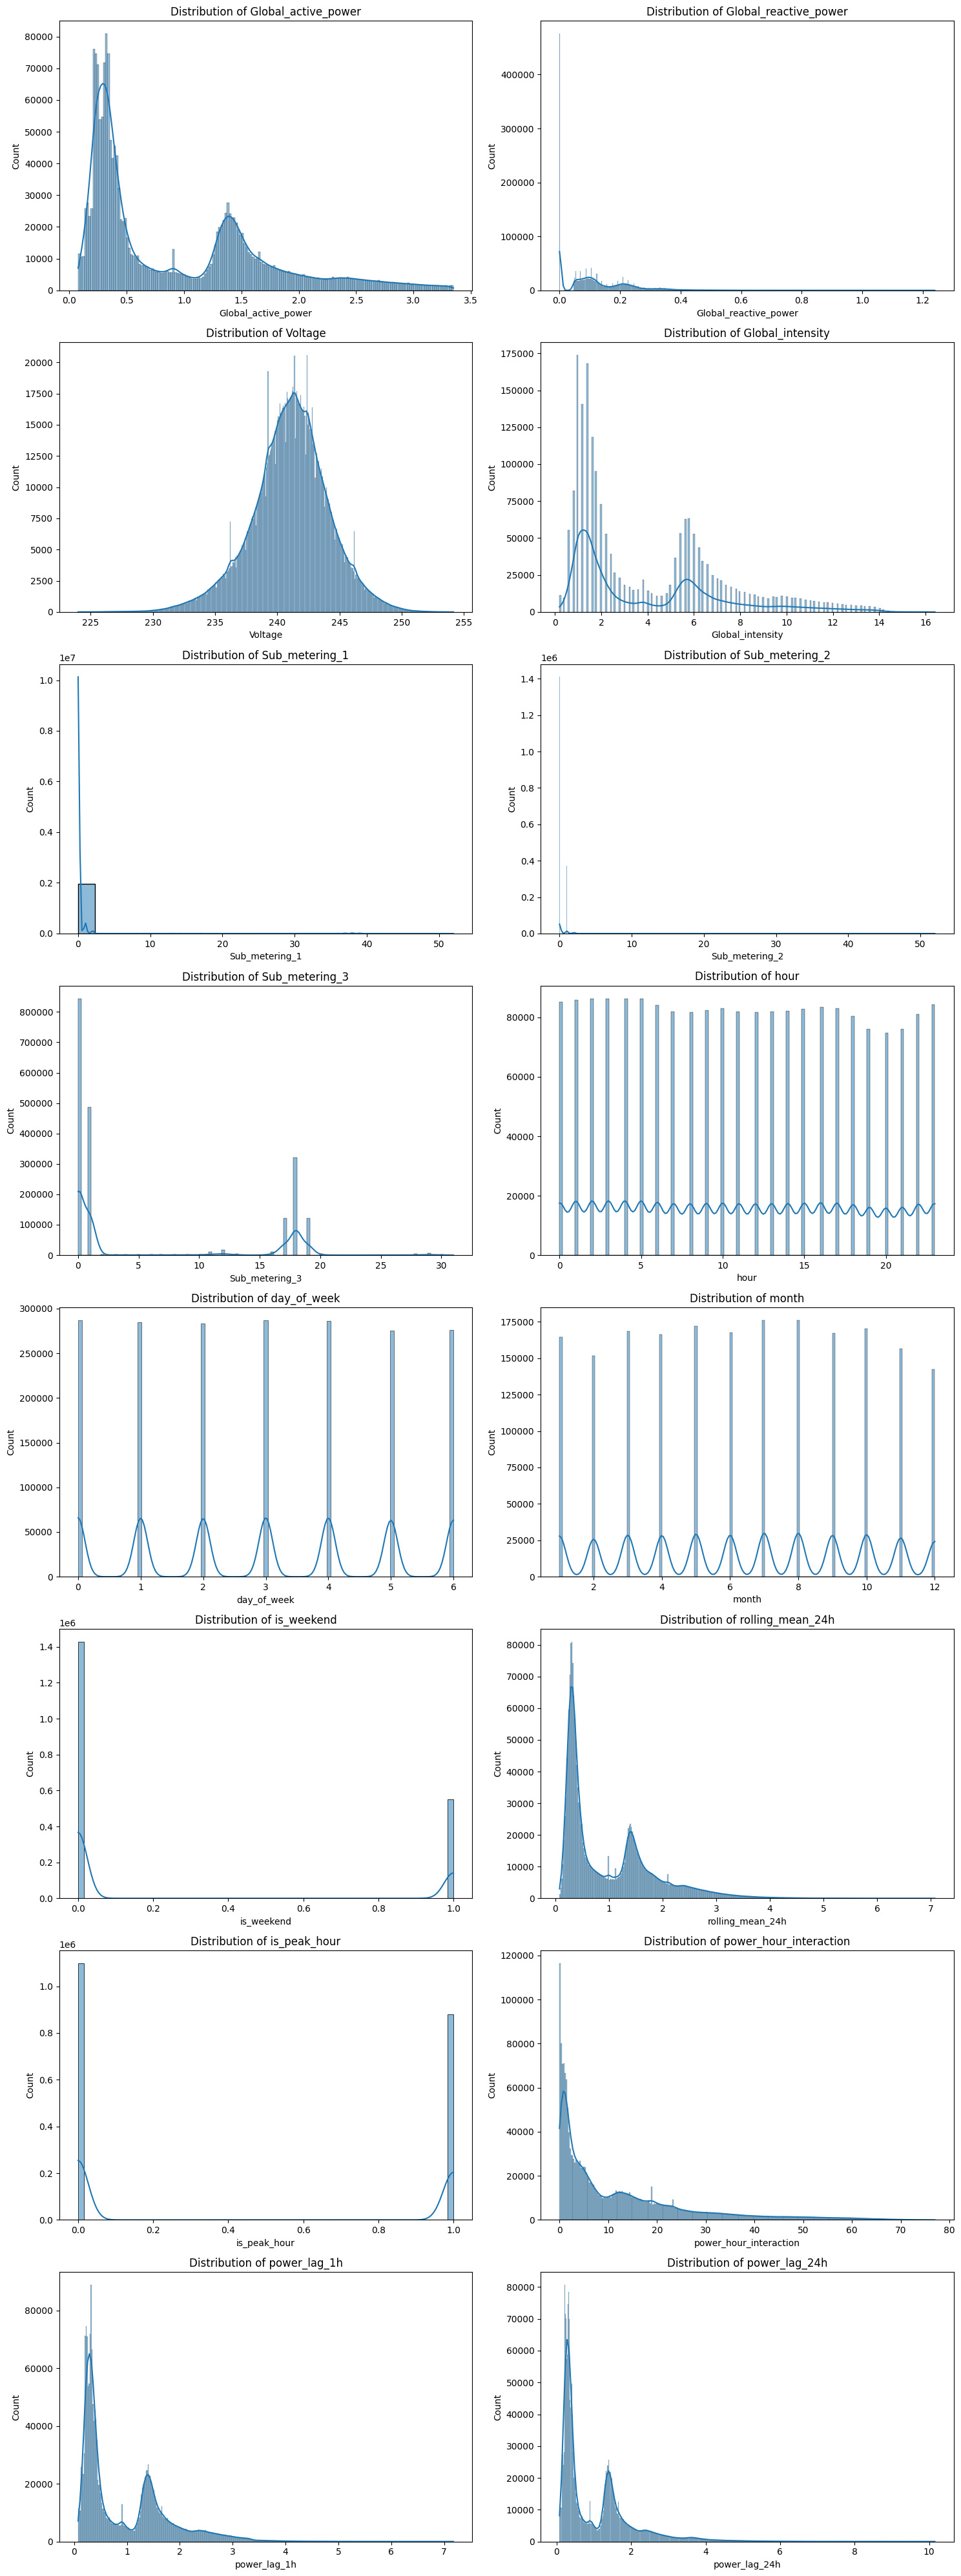

In [ ]:
# EDA Execution


#
#df = data.ffill()
#df.dropna()
#f_df.dtypes


# Incorrect data are droped as the % of incorrect data is minimul 1.25%
#Total Records 2075259
#Incorrect Recrods 25,979 (1.25%)
#f_df.count() After Filtering Records 2049280



plot_missing_values(f_df)

f_df = Handle_missing_values(f_df)
plot_missing_values(f_df)


plot_correlations(f_df)

temporal_analysis()

plot_submetering_comparison()


identify_outliers()
f_df_no_outliers = removal_outliers()

plot_distributions(f_df)
plot_distributions(f_df_no_outliers)





In [ ]:


def train_model(feature):
  #with no outliers

  x = f_df[feature_columns]
  y = f_df['Global_active_power']

  #x = f_df_no_outliers[feature_columns]
  #y = f_df_no_outliers['Global_active_power']

  # Scale features
  scaler = StandardScaler()
  x_scaled = scaler.fit_transform(x)
  y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

  #Train multiple regression models


  # Split data
  x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)




  # Define models with their hyperparameters
  models = {
      'Linear Regression': LinearRegression(),
      #'Decision Tree': DecisionTreeRegressor(max_depth=5),
      'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5),
      'Gradient Boosting': GradientBoostingRegressor(random_state=42),
      #'SVM': SVR(kernel='linear', C=1.0),  # RBF kernel for non-linear decision boundary
      'Neural Network': MLPRegressor(
          hidden_layer_sizes=(100, 50),  # Two hidden layers
          max_iter=1000,
          activation='relu',
          solver='adam',
          random_state=42
      )
  }


  # Dictionary to store results
  results = {}

  # Train and evaluate each model
  for name, model in models.items():
      print(f"\nTraining {name}...")

      # Train
      model.fit(x_train, y_train)

      # Predict
      y_pred = model.predict(x_test)
      y_test_original = scaler.inverse_transform(y_test)
      y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))

      rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
      mae = mean_absolute_error(y_test_original, y_pred_original)
      r2 = r2_score(y_test_original, y_pred_original)

      importance = None
      if name in ('Gradient Boosting','Random Forest') :
        importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': model.feature_importances_
            #'importance': model.coef_[0]
        })
        importance = importance.sort_values('importance', ascending=False)

      # Store results
      results[name] = {
          'y_predictions': y_pred_original,
          'y_test': y_test_original,

          #'accuracy': accuracy_score(y_test_original, y_pred_original),
          #'classification_report': classification_report(y_test_original, y_pred_original),
          'rmse': rmse,
          'mae': mae,
          'r2': r2,
          'importance' : importance
          }

      # Print metrics
      print("\nModel Performance Metrics: "+ name)
      print(f" Measures prediction accuracy - rmse : {rmse:.4f}")
      print(f" Evaluates average error magnitude - mae : {mae:.4f}")
      print(f" R-Squared : {r2:.4f}")


  """
  # Manual Method
  #Initialize and train model
  model = models['Linear Regression']


  model.fit(x_train, y_train)

  # Make predictions
  y_pred = model.predict(x_test)

  y_test_original = scaler.inverse_transform(y_test)
  y_pred_original = scaler.inverse_transform(y_pred)


  # Calculate metrics
  rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
  mae = mean_absolute_error(y_test_original, y_pred_original)
  r2 = r2_score(y_test_original, y_pred_original)

  # Print metrics
  print("\nModel Performance Metrics:")
  print(f" Measures prediction accuracy - rmse : {rmse:.4f}")
  print(f" Evaluates average error magnitude - mae : {mae:.4f}")
  print(f" R-Squared : {r2:.4f}")


  """

  return results





In [ ]:
# Visualize results

def Visualize_results(results):
  n_cols = 2
  n_rows = 1
  idx=0
  fig, axes = plt.subplots(n_rows, n_cols)
  axes = axes.ravel()

  for i, (name, result) in enumerate(results.items()): # use enumerate for axis indexing
    print(name)

    if name in ('Gradient Boosting','Random Forest') :

      """
      Analyze and visualize feature importance
      """


      importance = result['importance']

      plt.figure(figsize=(10, 6))
      sns.barplot(x='importance', y='feature', data=importance,ax=axes[idx])
      axes[idx].set_title(f'Feature Importance Analysis of {name}')
      idx=idx+1

      plt.tight_layout()
      plt.show()


  """
  Create visualization of actual vs predicted values
  """

  #, figsize=(15, 5*n_rows)

  n_cols = 2
  n_rows = (len(results) + 1) // 2

  fig, axes = plt.subplots(n_rows, n_cols)
  axes = axes.ravel()

  for idx, (name, result) in enumerate(results.items()): # use enumerate for axis indexing
    print(name)

    # Histogram
    #, kde=True
    y_predictions = result['y_predictions']
    y_test = result['y_test']
    # sns.scatterplot expects 1D arrays
    sns.scatterplot(x=y_test.ravel(), y=y_predictions.ravel(), ax=axes[idx], label=name) # use ravel to flatten arrays

    axes[idx].set_title(f'Distribution of {name}')
    axes[idx].set_xlabel('Actual Power Consumption') # Set xlabel for each subplot
    axes[idx].set_ylabel('Predicted Power Consumption') # Set ylabel for each subplot

    axes[idx].plot([y_test.min(), y_predictions.max()], [y_test.min(), y_predictions.max()], 'r--', lw=2)

  fig.suptitle('Actual vs Predicted Power Consumption') # Add overall title to the figure
  plt.tight_layout()
  plt.show()




In [ ]:
"""
Prepare feature matrix X and target variable y
"""
feature_columns = [
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_peak_hour',
    'rolling_mean_24h', 'power_lag_1h', 'power_lag_24h',
    'power_hour_interaction'
]

# replacing feature and selecting below feature based on correlation results
# Global_intensity ,Sub_metering_3 have strong relation with Global_active_power
# considering Sub_metering_3 becasue i have moderate relation with Global_intensity
feature_columns = [
    'Global_intensity', 'Sub_metering_3'
]


results = train_model(feature_columns)

Visualize_results (results)